# Cluster test - Mt Charlotte

cluster analysis tests

written by: Jennifer Paradis

Date: 31/03/2016

See link for more info:

http://scikit-learn.org/stable/modules/clustering.html

Updates:
- Jennifer Paradis, 12/04/2016: debugged
- Jennifer Paradis, 18/04/2016: added declustering and weighting of criteria
- Jennifer Paradis, 22/04/2016: added identification of 'commonly grouped' and assigning of 'unclassified' groups using K-nn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import itertools

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch

from scipy.cluster import hierarchy

from sklearn.neighbors import KNeighborsClassifier

# Set Variables

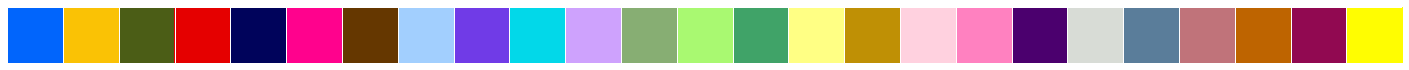

In [20]:
#composite file to import
fname = 'D:\\SMARTmodels\\01_Datasets\\05_Mt_Charlotte\\mtcmc_cmp2m_cmp_entry.csv'

#list of variables (columns) to group
listGroup = ['geocod']

#grade variable for stats calculations
varGrade1 = 'au1'

#decluster data using variable?
declLogic = True
#if above True, indicate declustering variable below
vardecl = 'decl'

#set number of clusters (for clustering algorithms that require it)
n_clusters = 4

#statistics to use for clusters, script set for 3 ('Mean','CV','Skewness','Median','StandardDev') along with their relative weighting (for no weighting, set to 1)
clusterParametersDict = {'Mean':10,'CV':5,'Skewness':5}

#set colors
color = (sns.xkcd_rgb["bright blue"],sns.xkcd_rgb["goldenrod"],sns.xkcd_rgb["army green"],sns.xkcd_rgb["red"],sns.xkcd_rgb["dark blue"],
         sns.xkcd_rgb["hot pink"],sns.xkcd_rgb["brown"],sns.xkcd_rgb["baby blue"],sns.xkcd_rgb["bluish purple"],sns.xkcd_rgb["aqua blue"],
         sns.xkcd_rgb['lilac'],sns.xkcd_rgb["sage"],sns.xkcd_rgb["spring green"],sns.xkcd_rgb["greenish"],sns.xkcd_rgb["pale yellow"],
         sns.xkcd_rgb["ochre"],sns.xkcd_rgb["light pink"],sns.xkcd_rgb["pink"],sns.xkcd_rgb["royal purple"],sns.xkcd_rgb["light grey"],
         sns.xkcd_rgb["steel blue"],sns.xkcd_rgb["dusty rose"],sns.xkcd_rgb["orange brown"],sns.xkcd_rgb["reddish purple"],sns.xkcd_rgb["bright yellow"]) 
sns.palplot(color)

# Import Data

In [7]:
df = pd.read_table((fname),',',low_memory=False)
#only keep assays > 0
df = df[df[varGrade1] >= 0]
#filter by Working_LTH_LC(...)
df = df[df['dommin'] == 2]

#weighted grade
if declLogic == True:
    df['weighted_grade'] = df[varGrade1]*df[vardecl]
if declLogic == False:
    vardecl = 'decl'
    df[vardecl] = 1
    df['weighted_grade'] = df[varGrade1]*df[vardecl]    

# Write Functions

In [36]:
clusterParameters = clusterParametersDict.keys()
def groupStats(dfInput, listGroup, varGrade, vardecl):
    group = dfInput.groupby(listGroup)
    dfGroupData = group[varGrade].count().reset_index()
    dfGroupData.rename(columns={''+varGrade+'': 'count'}, inplace=True)
    xxmedian,xxvar,xxmean,xxskew = (),(),(),()
    for j, grp in group:
        xxmedian = xxmedian + (grp[varGrade][grp['weighted_grade'] >= grp['weighted_grade'].median()].iloc[0],)
        weightedmean = np.average(grp[varGrade],weights=grp[vardecl])
        weightedvar = np.average((grp[varGrade]-weightedmean)**2,weights=grp[vardecl])
        xxmean = xxmean + (weightedmean,)            
        xxvar = xxvar + (weightedvar,)  
        xxskew = xxskew + (np.average((grp[varGrade]-weightedmean)**3, weights=grp[vardecl])/weightedvar**(1.5),)
    dfGroupData['Median'] = xxmedian
    dfGroupData['Mean'] = xxmean
    dfGroupData['Variance'] = xxvar
    dfGroupData['Skewness'] = xxskew     
    dfGroupData['StandardDev'] = dfGroupData.Variance**0.5
    dfGroupData['CV'] = dfGroupData.StandardDev/dfGroupData.Mean  
    dfGroupData = dfGroupData[dfGroupData['count'] > 2]
    return dfGroupData

def NormaliseWeightedDF(dfInput, normVarDict):
    dfNorm = dfInput.copy(deep=True)
    dfNormVarList = normVarDict.keys()
    for j in dfNormVarList:
        dfNorm[j] = (pd.DataFrame(dfNorm[j] - dfNorm[j].min(0)) / dfNorm[j].ptp(0))*normVarDict[j]       
    return dfNorm

def plotCluster3D(clusterParameters, dfInput, clusterType, color, clusterVar):
    plt.ion()
    #chart width and height
    w = 10
    h = 10
    
    fig = plt.figure(figsize=(w, h))
    ax=fig.add_subplot(111,projection='3d',xlabel=clusterParameters[0], ylabel=clusterParameters[1], zlabel=clusterParameters[2])
    
    for i, grp in dfInput.groupby(clusterVar):
        ax.scatter(grp[clusterParameters[0]],grp[clusterParameters[1]],grp[clusterParameters[2]],color=color[int(i)],label=i,alpha=1)

    if len(listGroup) == 1:    
        for j in dfInput[listGroup[0]]:
            #print j
            xx = dfInput.query(''+listGroup[0]+' == "'+str(j)+'"')
            ax.text(float(xx[clusterParameters[0]]),float(xx[clusterParameters[1]])+max(xx[clusterParameters[1]]/30),float(xx[clusterParameters[2]]), j)
        
    #ax.view_init(90,-45)
    plt.tight_layout()
    plt.title(clusterType)
    plt.legend()
    plt.xlim(min(dfInput[clusterParameters[0]]),max(dfInput[clusterParameters[0]]))
    plt.ylim(min(dfInput[clusterParameters[1]]),max(dfInput[clusterParameters[1]]))
    ax.set_zlim(min(dfInput[clusterParameters[2]]),max(dfInput[clusterParameters[2]]))
    return plt

def plotCluster3DCommon(clusterParameters, dfInput, clusterType, color, clusterVar):
    plt.ion()
    #chart width and height
    w = 10
    h = 10
    
    fig = plt.figure(figsize=(w, h))
    ax=fig.add_subplot(111,projection='3d',xlabel=clusterParameters[0], ylabel=clusterParameters[1], zlabel=clusterParameters[2])
    
    #plot common allocated sub-groups
    xx = dfInput.query('ClusterCommon>0')
    for i, grp in xx.groupby(clusterVar):
        ax.scatter(grp[clusterParameters[0]],grp[clusterParameters[1]],grp[clusterParameters[2]],color=color[int(i)],label=int(i),alpha=1)
    #plot unallocated sub-groups
    xx = dfInput.query('ClusterCommon==0')
    for i, grp in xx.groupby(clusterVar):
        ax.scatter(grp[clusterParameters[0]],grp[clusterParameters[1]],grp[clusterParameters[2]],color=color[int(i)],s=50,marker='s',label=int(i),alpha=1)        
    
    if len(listGroup) == 1:    
        for j in dfInput[listGroup[0]]:
            #print j
            xx = dfInput.query(''+listGroup[0]+' == "'+str(j)+'"')
            ax.text(float(xx[clusterParameters[0]]),float(xx[clusterParameters[1]])+max(xx[clusterParameters[1]]/30),float(xx[clusterParameters[2]]), j)
        
    #ax.view_init(90,-45)
    plt.tight_layout()
    plt.title('Cluster Allocation')
    plt.legend()
    plt.xlim(min(dfInput[clusterParameters[0]]),max(dfInput[clusterParameters[0]]))
    plt.ylim(min(dfInput[clusterParameters[1]]),max(dfInput[clusterParameters[1]]))
    ax.set_zlim(min(dfInput[clusterParameters[2]]),max(dfInput[clusterParameters[2]]))
    return plt

# Start Work

#### group data by chosen grouping variables and create columns of stats

In [12]:
dfGroupData = groupStats(df, listGroup, varGrade1, vardecl) # raw
dfGroupDataNorm = NormaliseWeightedDF(dfGroupData, clusterParametersDict) # normalised
dfCluster = pd.DataFrame(dfGroupData[listGroup])

### Plot Data

## K-mean

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans

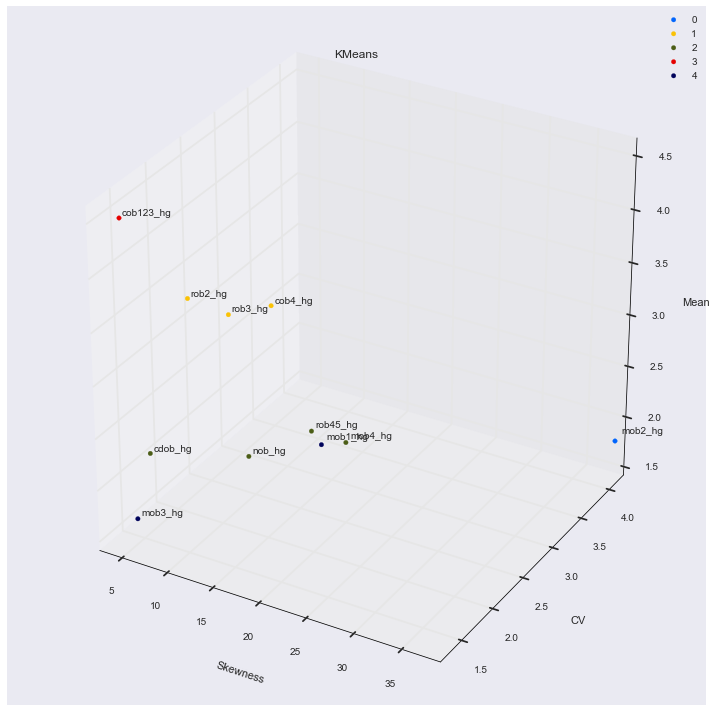

In [27]:
clusterType = 'KMeans'

#set number of clusters

n_clusters = 5

clusterParametersDict = {'Mean':5,'CV':5,'Skewness':5}

#cluster analysis
dfGroupData['Cluster'] = KMeans(n_clusters=n_clusters).fit_predict(dfGroupDataNorm[clusterParameters].as_matrix())
dfCluster[clusterType] = dfGroupData['Cluster']

#add domains from cluster analysis to input composite file & export
dfOut = df.set_index(listGroup).join(dfGroupData.set_index(listGroup).Cluster).reset_index()
dfOut.to_csv('Cmp_withCluster_'+clusterType+'.csv',index=False)

#plot
plotCluster3D(clusterParameters, dfGroupData, clusterType, color, 'Cluster')
#export plot
plt.savefig('ClusterAnalysis_'+clusterType+'.png', format='png', dpi=100) 

## AffinityPropagation

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation

seems very sensitive to the 'damping' parameter

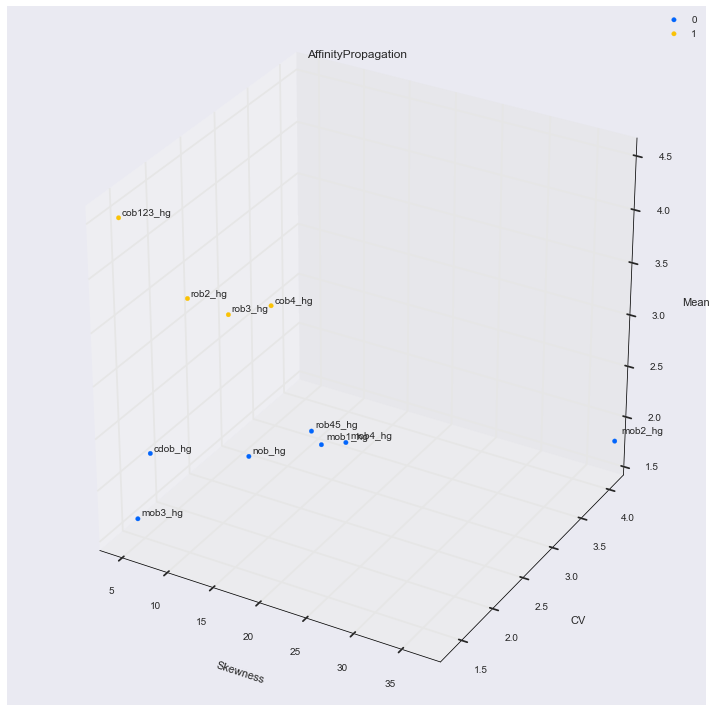

In [28]:
clusterType = 'AffinityPropagation'

####
#Damping factor between 0.5 and 1.
damping = 0.8

#cluster analysis
dfGroupData['Cluster'] = AffinityPropagation(damping=damping).fit_predict(dfGroupDataNorm[clusterParameters].as_matrix())
dfCluster[clusterType] = dfGroupData['Cluster']

#add domains from cluster analysis to input composite file & export
dfOut = df.set_index(listGroup).join(dfGroupData.set_index(listGroup).Cluster).reset_index()
dfOut.to_csv('Cmp_withCluster_'+clusterType+'.csv',index=False)

###PLOT
plotCluster3D(clusterParameters, dfGroupData, clusterType, color, 'Cluster')
#export plot
plt.savefig('ClusterAnalysis_'+clusterType+'.png', format='png', dpi=100) 

## Mean Shift

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html#sklearn.cluster.MeanShift

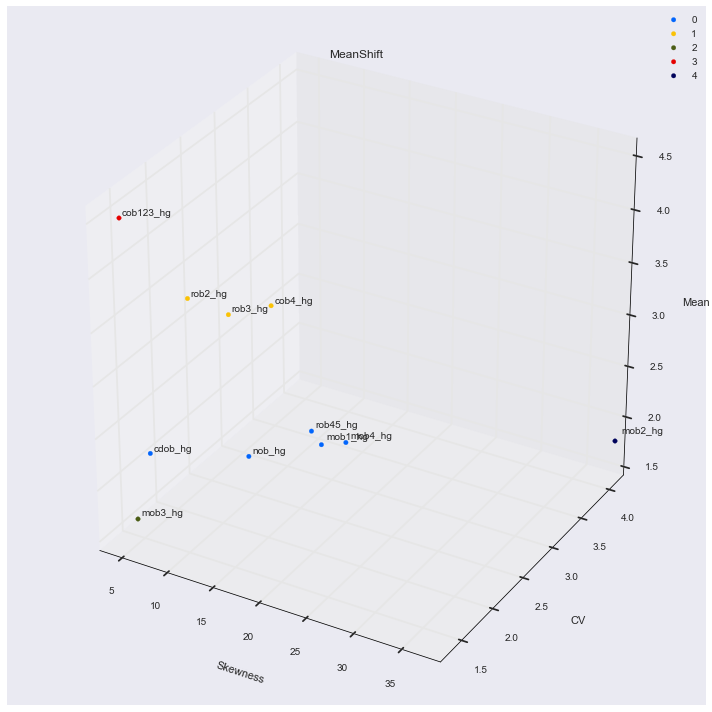

In [29]:
clusterType = 'MeanShift'

#cluster analysis
dfGroupData['Cluster'] = MeanShift().fit_predict(dfGroupDataNorm[clusterParameters].as_matrix())
dfCluster[clusterType] = dfGroupData['Cluster']

#add domains from cluster analysis to input composite file & export
dfOut = df.set_index(listGroup).join(dfGroupData.set_index(listGroup).Cluster).reset_index()
dfOut.to_csv('Cmp_withCluster_'+clusterType+'.csv',index=False)

###PLOT
plotCluster3D(clusterParameters, dfGroupData, clusterType, color, 'Cluster')
#export plot
plt.savefig('ClusterAnalysis_'+clusterType+'.png', format='png', dpi=100) 

## Spectral clustering

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering

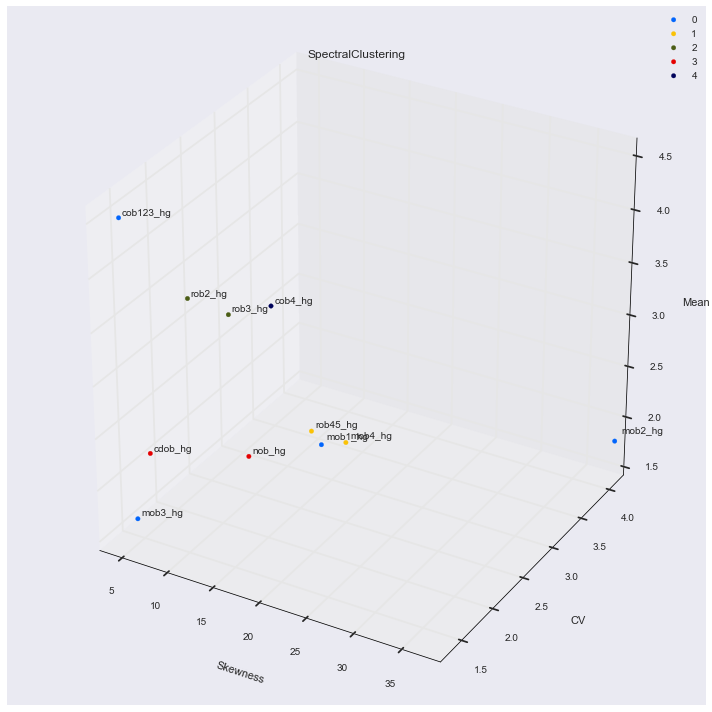

In [30]:
clusterType = 'SpectralClustering'

#set number of clusters
#n_clusters = 3

#cluster analysis
dfGroupData['Cluster'] = SpectralClustering(n_clusters=n_clusters).fit_predict(dfGroupDataNorm[clusterParameters].as_matrix())
dfCluster[clusterType] = dfGroupData['Cluster']

#add domains from cluster analysis to input composite file & export
dfOut = df.set_index(listGroup).join(dfGroupData.set_index(listGroup).Cluster).reset_index()
dfOut.to_csv('Cmp_withCluster_'+clusterType+'.csv',index=False)

#plot
plotCluster3D(clusterParameters, dfGroupData, clusterType, color, 'Cluster')
#export plot
plt.savefig('ClusterAnalysis_'+clusterType+'.png', format='png', dpi=100) 

## Hierarchical clustering

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering

ward and average linkage seem to give most reasoble results

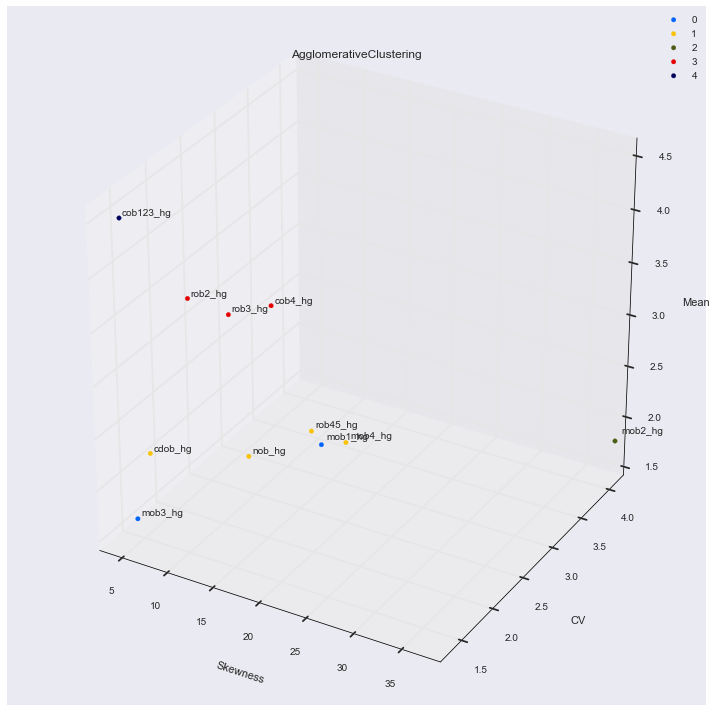

In [31]:
clusterType = 'AgglomerativeClustering'

#set number of clusters
#n_clusters = 3

#####
#Which linkage criterion to use. The linkage criterion determines which distance to use between sets of observation.
#The algorithm will merge the pairs of cluster that minimize this criterion.
#----
#ward:     minimizes the variance of the clusters being merged.
#complete: average uses the average of the distances of each observation of the two sets.
#average:  complete or maximum linkage uses the maximum distances between all observations of the two sets.
#####
linkage= 'average'

#####
#Metric used to compute the linkage
#If linkage is “ward”, only “euclidean” is accepted.
#----
#“euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or ‘precomputed’
#####
affinity = 'euclidean'

#cluster analysis
dfGroupData['Cluster'] = AgglomerativeClustering(n_clusters=n_clusters,linkage=linkage, affinity=affinity).fit_predict(dfGroupDataNorm[clusterParameters].as_matrix())
dfCluster[clusterType] = dfGroupData['Cluster']

#add domains from cluster analysis to input composite file & export
dfOut = df.set_index(listGroup).join(dfGroupData.set_index(listGroup).Cluster).reset_index()
dfOut.to_csv('Cmp_withCluster_'+clusterType+'.csv',index=False)

#plot
plotCluster3D(clusterParameters, dfGroupData, clusterType, color, 'Cluster')
#export plot
plt.savefig('ClusterAnalysis_'+clusterType+'.png', format='png', dpi=100) 

## DBSCAN

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN

Doesn't seem to work.  I must be doing something wrong.  Not sure what to set as the metric??

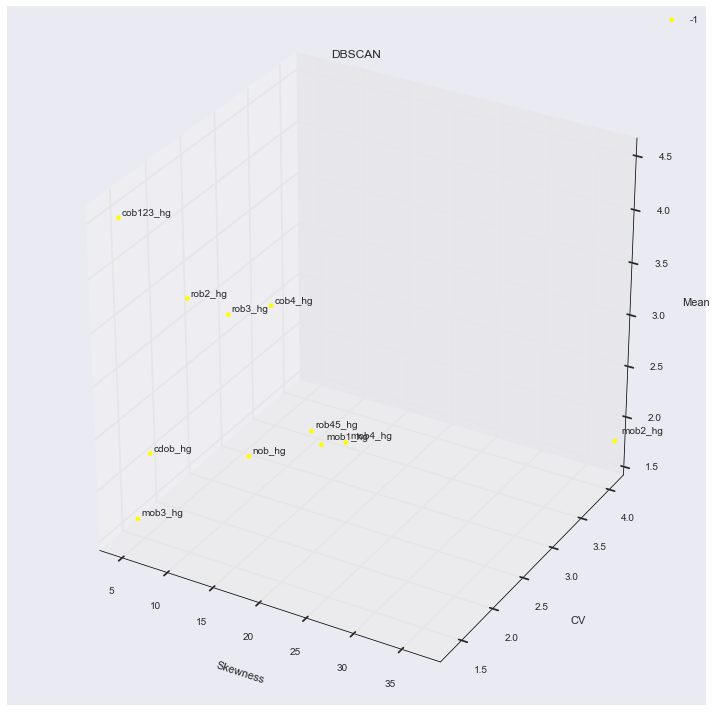

In [32]:
clusterType = 'DBSCAN'

#set number of clusters
#n_clusters = 3

####
#The metric to use when calculating distance between instances in a feature array.
#If metric is a string or callable, it must be one of the options allowed by metrics.pairwise.calculate_distance for its metric parameter.
#If metric is “precomputed”, X is assumed to be a distance matrix and must be square. X may be a sparse matrix,
#in which case only “nonzero” elements may be considered neighbors for DBSCAN.
#metric=''

####
#The algorithm to be used by the NearestNeighbors module to compute pointwise distances and find nearest neighbors.
#----
#‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’
algorithm = 'auto'

#cluster analysis
dfGroupData['Cluster'] = DBSCAN(algorithm=algorithm).fit_predict(dfGroupDataNorm[clusterParameters].as_matrix())
dfCluster[clusterType] = dfGroupData['Cluster']

#add domains from cluster analysis to input composite file & export
dfOut = df.set_index(listGroup).join(dfGroupData.set_index(listGroup).Cluster).reset_index()
dfOut.to_csv('Cmp_withCluster_'+clusterType+'.csv',index=False)

#plot
plotCluster3D(clusterParameters, dfGroupData, clusterType, color, 'Cluster')
#export plot
plt.savefig('ClusterAnalysis_'+clusterType+'.png', format='png', dpi=100) 

## Birch

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html#sklearn.cluster.Birch

sensitive to the 'threshold' parameter

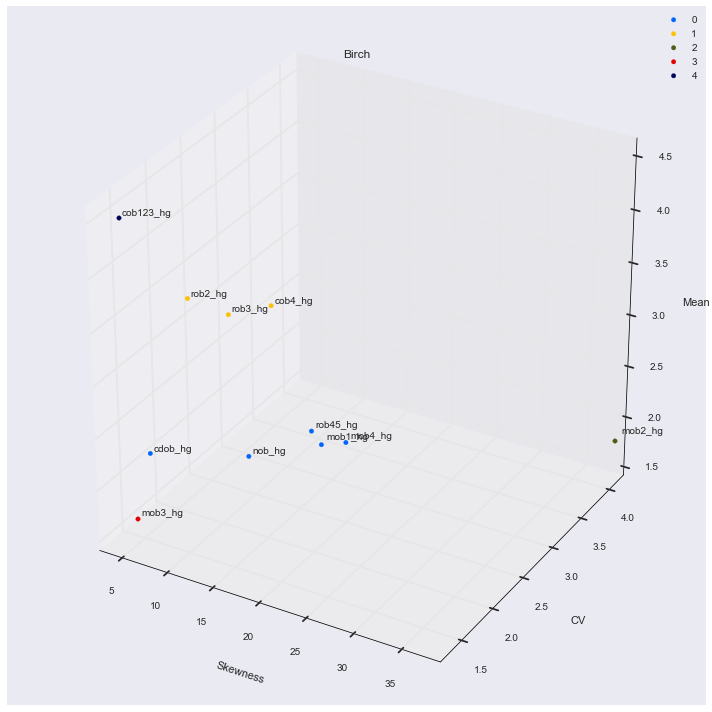

In [33]:
clusterType = 'Birch'

#set number of clusters
#n_clusters = 3

####
#The radius of the subcluster obtained by merging a new sample and the closest subcluster should be lesser than the threshold.
#Otherwise a new subcluster is started.
#----
#float, default 0.5
threshold = 0.05

#cluster analysis
dfGroupData['Cluster'] = Birch(n_clusters=n_clusters,threshold=threshold).fit_predict(dfGroupDataNorm[clusterParameters].as_matrix())
dfCluster[clusterType] = dfGroupData['Cluster']

#add domains from cluster analysis to input composite file & export
dfOut = df.set_index(listGroup).join(dfGroupData.set_index(listGroup).Cluster).reset_index()
dfOut.to_csv('Cmp_withCluster_'+clusterType+'.csv',index=False)

#plot
plotCluster3D(clusterParameters, dfGroupData, clusterType, color, 'Cluster')
#export plot
plt.savefig('ClusterAnalysis_'+clusterType+'.png', format='png', dpi=100) 

## Identify sub-groups commonly clustered, then classify remaining unallocated sub-groups using K-NN

http://scikit-learn.org/stable/modules/neighbors.html#classification

<module 'matplotlib.pyplot' from 'C:\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

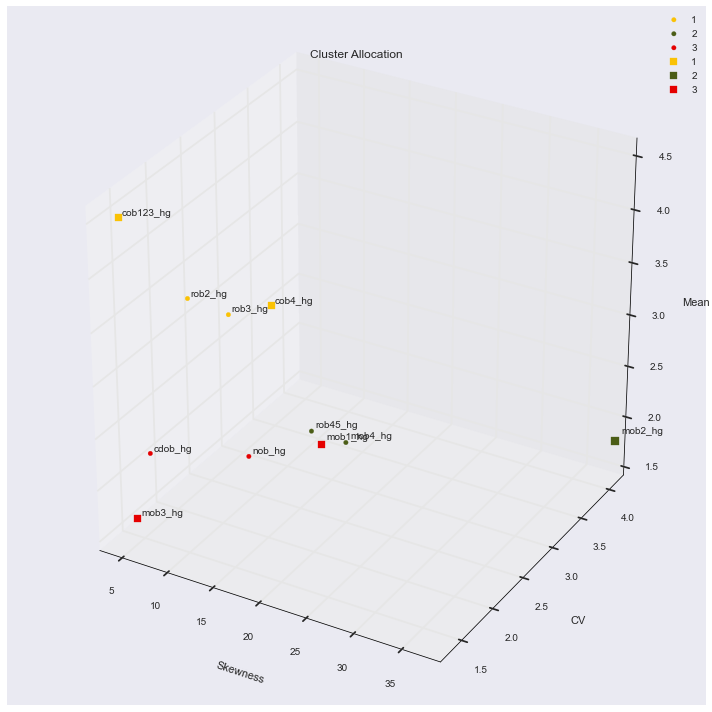

In [40]:
#list of clustering algorithms used for 'common clustering' assignment
listClustAlgorithm = ['KMeans','Birch','AgglomerativeClustering','SpectralClustering']
#Mininmum number of sub-groups in 'common clustering' group (groups with less than this will be deemed 'unallocated')
minSubgroup = 2

#Identify commonly clustered subgroups (column named 'ClusterCommon')
dfClusterCommon = dfCluster.groupby(listClustAlgorithm)[listGroup].count().sort_values(listGroup[:1],ascending=False).query(''+listGroup[0]+' >='+str(minSubgroup)+'').reset_index()
dfClusterCommon['ClusterCommon'] = dfClusterCommon.index+1
xxCluster1 = dfCluster.set_index(listClustAlgorithm).join(dfClusterCommon[listClustAlgorithm+['ClusterCommon']].set_index(listClustAlgorithm)).reset_index()[listGroup+['ClusterCommon']].set_index(listGroup).fillna(0).astype(int, inplace=True)
dfCluster1 = df.set_index(listGroup).join(xxCluster1).reset_index()
dfGroupDataCluster1 = dfGroupData.set_index(listGroup).join(xxCluster1).reset_index().fillna(0)
dfGroupDataNormCluster1 = dfGroupDataNorm.set_index(listGroup).join(xxCluster1).reset_index().fillna(0)

#Classify unallocated sub-groups using 'commonly clustered' sub-domains as training dataset - using K-NN (column named 'ClusterUnallocated')
X = dfGroupDataNormCluster1.query('ClusterCommon > 0')[clusterParameters].as_matrix() # training dataset
y = dfGroupDataNormCluster1.query('ClusterCommon > 0')['ClusterCommon'].as_matrix() # target dataset
neigh = KNeighborsClassifier(n_neighbors=3)
z = dfGroupDataNormCluster1.query('ClusterCommon == 0')[clusterParameters].as_matrix() # unknown dataset
xxUnknown = dfGroupDataNormCluster1.query('ClusterCommon == 0').copy(deep=True)
xxUnknown['ClusterUnallocated'] = neigh.fit(X, y).predict(z)
dfCluster1 = dfCluster1.set_index(listGroup).join(xxUnknown.set_index(listGroup)['ClusterUnallocated']).reset_index()
dfGroupDataCluster1 = dfGroupDataCluster1.set_index(listGroup).join(xxUnknown.set_index(listGroup)['ClusterUnallocated']).reset_index().fillna(0)
dfGroupDataNormCluster1 = dfGroupDataNormCluster1.set_index(listGroup).join(xxUnknown.set_index(listGroup)['ClusterUnallocated']).reset_index().fillna(0)

#combine 'ClusterCommon' and 'ClusterUnallocated' to create 'ClusterFinal' domaining field
dfCluster1['ClusterFinal'] = dfCluster1['ClusterCommon']+dfCluster1['ClusterUnallocated']
dfGroupDataCluster1['ClusterFinal'] = dfGroupDataCluster1['ClusterCommon']+dfGroupDataCluster1['ClusterUnallocated']
dfGroupDataNormCluster1['ClusterFinal'] = dfGroupDataNormCluster1['ClusterCommon']+dfGroupDataNormCluster1['ClusterUnallocated']

#plot (smaller round points are the initially allocated ‘common cluster’ sub-groups, and the larger square points and subsequently allocated subgroups)
plotCluster3DCommon(clusterParameters, dfGroupDataCluster1, clusterType, color, 'ClusterFinal')

In [82]:
dfClusterCommon

,KMeans,Birch,AgglomerativeClustering,SpectralClustering,domfsm,ClusterCommon
0,3,4,0,0,6,1
1,5,2,1,3,4,2
2,2,5,2,4,3,3
3,1,1,0,1,2,4
4,1,1,0,5,2,5
